**g16**
- anderdav@students.zhaw.ch
- goodnic1@students.zhaw.ch
- janick.rueegger@students.fhnw.ch
- neyerjoh@students.zhaw.ch

# Exercise 2: Shallow networks on CIFAR10

In [1]:
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
rng = np.random.default_rng()

In [2]:
Transform = ToTensor()

train_data = datasets.CIFAR10(
    root = "../data",
    train = True,                         
    transform = Transform, 
    download = True,            
)

test_data = datasets.CIFAR10(
    root = "../data", 
    train = False, 
    transform = Transform,
    download = True
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: ToTensor()

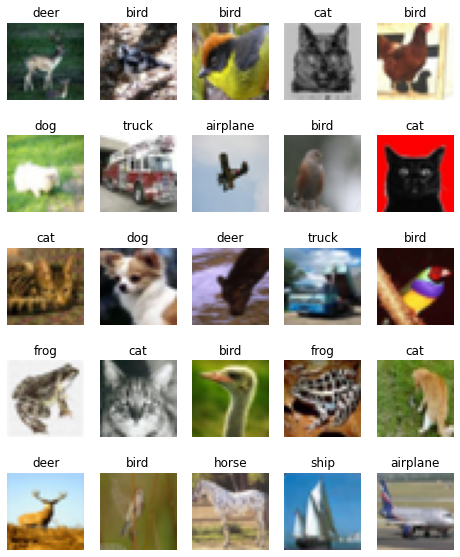

In [5]:
def show_imgs(X):
    figure = plt.figure(figsize=(8, 10))
    cols, rows = 5, 5
    for i in range(1, cols * rows + 1):
        img, label = X[rng.integers(len(X))]
        figure.add_subplot(rows, cols, i)
        plt.title(X.classes[label])
        plt.axis("off")
        plt.imshow(img.permute(1,2,0))
    plt.show()
    
show_imgs(train_data)

In [6]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

n_classes = len(train_data.classes)
input_size = np.prod(train_data.data.shape[1:])

In [7]:
def train(epoch, model, data_loader, log_interval=200):
    
    model.train()
    
    total_train_loss = 0
    total_correct = 0
    
    for batch_idx, (data, target) in enumerate(tqdm(data_loader, desc=f"Training Epoch {epoch}")):
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = criterion(output, target)

        loss.backward()
        
        optimizer.step()
        
        total_train_loss += loss.item()
        
        pred = output.argmax(dim=1)
        
        total_correct += torch.sum(pred == target).item()

        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{:5}/{:5} ({:2.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx * len(data), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.data.item()))

    accuracy_train = total_correct / len(data_loader.dataset)

    total_train_loss = total_train_loss / len(data_loader)

    return {
        "loss": total_train_loss,
        "accuracy": accuracy_train,
    }

In [8]:
@torch.inference_mode()
def validate(model, data_loader):
   
    model.eval()
    
    val_loss = 0
    total_correct = 0
    total_preds = []
    total_targets = []
    
    for data, target in tqdm(data_loader, desc="Validation"):
        output = model(data)
        val_loss += criterion(output, target).item()
        
        pred = output.argmax(dim=1)
        total_correct += torch.sum(pred == target).item()
        total_preds.append(pred.detach().cpu())
        total_targets.append(target.cpu())

    val_loss /= len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    
    print("Validation set: Average loss: {:.4f}, Accuracy: {:5}/{:5} ({:2.2f}%)\n".format(
        val_loss, total_correct, len(data_loader.dataset), 100 * accuracy))
    
    return {
        "loss": val_loss,
        "accuracy": accuracy,
        "predictions": torch.cat(total_preds),
        "targets": torch.cat(total_targets),
    }

## One-Layer Network

In [9]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, n_classes),
    nn.Softmax(dim=0))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), weight_decay=0.05)

summary(model, input_size=(1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                   [-1, 10]          30,730
           Softmax-3                   [-1, 10]               0
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 0.12
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


In [10]:
%%time

epochs = 5

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [    0/50000 ( 0%)]	Loss: 2.302747
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.298643


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.3004, Accuracy:  2645/10000 (26.45%)



Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [    0/50000 ( 0%)]	Loss: 2.300768
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.300169


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2999, Accuracy:  2521/10000 (25.21%)



Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [    0/50000 ( 0%)]	Loss: 2.298850
Train Epoch: 3 [25600/50000 (51%)]	Loss: 2.298896


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2995, Accuracy:  2500/10000 (25.00%)



Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [    0/50000 ( 0%)]	Loss: 2.298379
Train Epoch: 4 [25600/50000 (51%)]	Loss: 2.298887


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2998, Accuracy:  2696/10000 (26.96%)



Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [    0/50000 ( 0%)]	Loss: 2.299816
Train Epoch: 5 [25600/50000 (51%)]	Loss: 2.300393


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.3004, Accuracy:  2534/10000 (25.34%)

CPU times: user 1min 11s, sys: 126 ms, total: 1min 11s
Wall time: 22.3 s


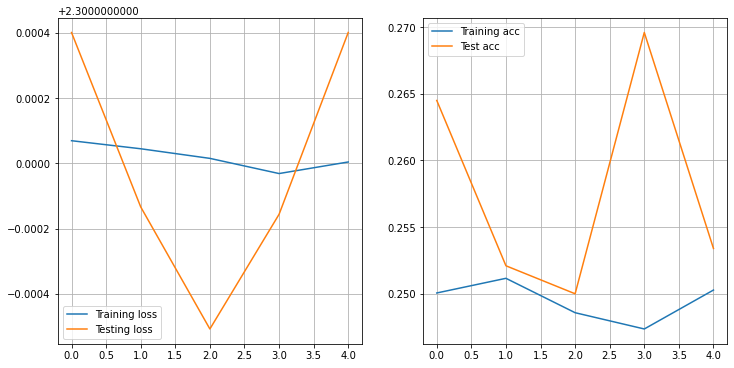

In [11]:
f = plt.figure(figsize=(12,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

In [12]:
confusion_matrix(val_result["predictions"], val_result["targets"])

array([[543, 126, 227, 159,  89, 144,  95, 128, 271, 126],
       [ 51, 213,  55,  55,  58,  29,  45,  49,  58, 131],
       [ 17,  10,  32,  20,  22,  13,  10,  13,  14,   6],
       [  3,  15,  22,  31,  19,  23,  30,  20,   5,  11],
       [ 20,  56, 149, 127, 270, 106, 152, 150,  14,  25],
       [ 41,  87, 115, 225, 157, 339, 158, 145,  95,  45],
       [ 63, 137, 194, 167, 181, 121, 330,  82,  44,  49],
       [ 30,  32, 102,  99, 100, 118, 109, 173,   7,  48],
       [ 42,  30,  29,  12,  22,  38,  12,  23,  68,  24],
       [190, 294,  75, 105,  82,  69,  59, 217, 424, 535]])

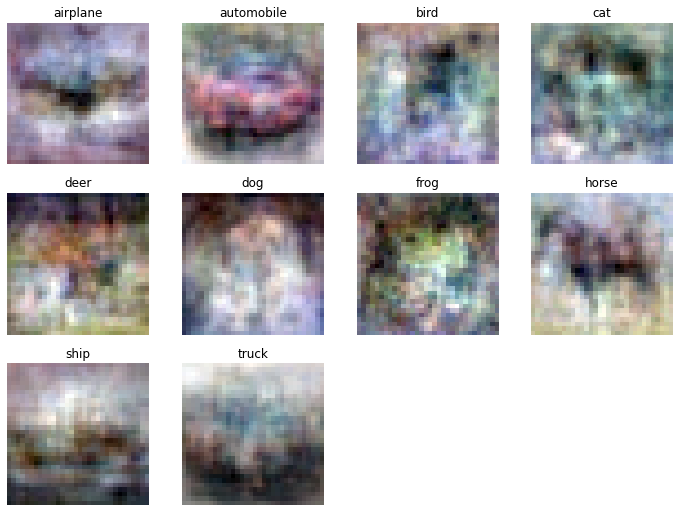

In [13]:
classifier_weight = dict(model.named_parameters())["1.weight"].detach().clone()

fig = plt.figure(figsize=(12,12))

cols = rows = int(ceil(sqrt(n_classes)))

for i, weight in enumerate(classifier_weight):
    ax = fig.add_subplot(rows, cols, 1+i)
    img = weight.reshape(train_data[0][0].shape)
    for channel in img:
        channel -= channel.min()
        channel *= 255 / channel.max()
    ax.axis('off')
    plt.title(train_data.classes[i])
    ax.imshow(img.type(torch.int64).permute(1,2,0))

## Two-Layer Network

In [14]:
n_hidden_layer_neurons = 256

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(input_size, n_hidden_layer_neurons),
    nn.ReLU(),
    nn.Linear(n_hidden_layer_neurons, n_classes),
    nn.Softmax(dim=0))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

summary(model, input_size=(1, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                 [-1, 3072]               0
            Linear-2                  [-1, 256]         786,688
              ReLU-3                  [-1, 256]               0
            Linear-4                   [-1, 10]           2,570
           Softmax-5                   [-1, 10]               0
Total params: 789,258
Trainable params: 789,258
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.03
Params size (MB): 3.01
Estimated Total Size (MB): 3.05
----------------------------------------------------------------


In [15]:
%%time

epochs = 50

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, epochs + 1):
    train_result = train(epoch, model, train_loader)
    train_losses.append(train_result["loss"])
    train_accuracies.append(train_result["accuracy"])
    
    val_result = validate(model, test_loader)
    val_losses.append(val_result["loss"])
    val_accuracies.append(val_result["accuracy"])

Training Epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 1 [    0/50000 ( 0%)]	Loss: 2.302597
Train Epoch: 1 [25600/50000 (51%)]	Loss: 2.267335


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2682, Accuracy:  3031/10000 (30.31%)



Training Epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 2 [    0/50000 ( 0%)]	Loss: 2.268497
Train Epoch: 2 [25600/50000 (51%)]	Loss: 2.271715


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2666, Accuracy:  3025/10000 (30.25%)



Training Epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 3 [    0/50000 ( 0%)]	Loss: 2.259846
Train Epoch: 3 [25600/50000 (51%)]	Loss: 2.264353


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2657, Accuracy:  3047/10000 (30.47%)



Training Epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 4 [    0/50000 ( 0%)]	Loss: 2.276136
Train Epoch: 4 [25600/50000 (51%)]	Loss: 2.262437


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2651, Accuracy:  3088/10000 (30.88%)



Training Epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 5 [    0/50000 ( 0%)]	Loss: 2.257401
Train Epoch: 5 [25600/50000 (51%)]	Loss: 2.257372


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2644, Accuracy:  3174/10000 (31.74%)



Training Epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 6 [    0/50000 ( 0%)]	Loss: 2.270356
Train Epoch: 6 [25600/50000 (51%)]	Loss: 2.262313


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2629, Accuracy:  3214/10000 (32.14%)



Training Epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 7 [    0/50000 ( 0%)]	Loss: 2.263715
Train Epoch: 7 [25600/50000 (51%)]	Loss: 2.260122


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2620, Accuracy:  3339/10000 (33.39%)



Training Epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 8 [    0/50000 ( 0%)]	Loss: 2.255823
Train Epoch: 8 [25600/50000 (51%)]	Loss: 2.253096


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2627, Accuracy:  3190/10000 (31.90%)



Training Epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 9 [    0/50000 ( 0%)]	Loss: 2.269808
Train Epoch: 9 [25600/50000 (51%)]	Loss: 2.260174


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2613, Accuracy:  3418/10000 (34.18%)



Training Epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 10 [    0/50000 ( 0%)]	Loss: 2.261711
Train Epoch: 10 [25600/50000 (51%)]	Loss: 2.240677


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2619, Accuracy:  3340/10000 (33.40%)



Training Epoch 11:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 11 [    0/50000 ( 0%)]	Loss: 2.275885
Train Epoch: 11 [25600/50000 (51%)]	Loss: 2.253876


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2633, Accuracy:  3362/10000 (33.62%)



Training Epoch 12:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 12 [    0/50000 ( 0%)]	Loss: 2.247979
Train Epoch: 12 [25600/50000 (51%)]	Loss: 2.266125


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2622, Accuracy:  3327/10000 (33.27%)



Training Epoch 13:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 13 [    0/50000 ( 0%)]	Loss: 2.266137
Train Epoch: 13 [25600/50000 (51%)]	Loss: 2.252573


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2609, Accuracy:  3396/10000 (33.96%)



Training Epoch 14:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 14 [    0/50000 ( 0%)]	Loss: 2.259647
Train Epoch: 14 [25600/50000 (51%)]	Loss: 2.245879


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2607, Accuracy:  3367/10000 (33.67%)



Training Epoch 15:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 15 [    0/50000 ( 0%)]	Loss: 2.251850
Train Epoch: 15 [25600/50000 (51%)]	Loss: 2.267051


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2589, Accuracy:  3403/10000 (34.03%)



Training Epoch 16:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 16 [    0/50000 ( 0%)]	Loss: 2.245908
Train Epoch: 16 [25600/50000 (51%)]	Loss: 2.262767


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2589, Accuracy:  3486/10000 (34.86%)



Training Epoch 17:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 17 [    0/50000 ( 0%)]	Loss: 2.257768
Train Epoch: 17 [25600/50000 (51%)]	Loss: 2.256852


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2587, Accuracy:  3442/10000 (34.42%)



Training Epoch 18:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 18 [    0/50000 ( 0%)]	Loss: 2.247837
Train Epoch: 18 [25600/50000 (51%)]	Loss: 2.241722


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2585, Accuracy:  3399/10000 (33.99%)



Training Epoch 19:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 19 [    0/50000 ( 0%)]	Loss: 2.261061
Train Epoch: 19 [25600/50000 (51%)]	Loss: 2.250518


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2577, Accuracy:  3437/10000 (34.37%)



Training Epoch 20:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 20 [    0/50000 ( 0%)]	Loss: 2.242608
Train Epoch: 20 [25600/50000 (51%)]	Loss: 2.257468


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2585, Accuracy:  3368/10000 (33.68%)



Training Epoch 21:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 21 [    0/50000 ( 0%)]	Loss: 2.248561
Train Epoch: 21 [25600/50000 (51%)]	Loss: 2.243574


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2600, Accuracy:  3384/10000 (33.84%)



Training Epoch 22:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 22 [    0/50000 ( 0%)]	Loss: 2.252197
Train Epoch: 22 [25600/50000 (51%)]	Loss: 2.257571


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2567, Accuracy:  3481/10000 (34.81%)



Training Epoch 23:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 23 [    0/50000 ( 0%)]	Loss: 2.237989
Train Epoch: 23 [25600/50000 (51%)]	Loss: 2.244234


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2583, Accuracy:  3493/10000 (34.93%)



Training Epoch 24:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 24 [    0/50000 ( 0%)]	Loss: 2.276803
Train Epoch: 24 [25600/50000 (51%)]	Loss: 2.258662


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2573, Accuracy:  3482/10000 (34.82%)



Training Epoch 25:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 25 [    0/50000 ( 0%)]	Loss: 2.253048
Train Epoch: 25 [25600/50000 (51%)]	Loss: 2.238040


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2570, Accuracy:  3454/10000 (34.54%)



Training Epoch 26:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 26 [    0/50000 ( 0%)]	Loss: 2.245188
Train Epoch: 26 [25600/50000 (51%)]	Loss: 2.240918


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2561, Accuracy:  3506/10000 (35.06%)



Training Epoch 27:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 27 [    0/50000 ( 0%)]	Loss: 2.249492
Train Epoch: 27 [25600/50000 (51%)]	Loss: 2.236316


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2572, Accuracy:  3556/10000 (35.56%)



Training Epoch 28:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 28 [    0/50000 ( 0%)]	Loss: 2.253545
Train Epoch: 28 [25600/50000 (51%)]	Loss: 2.265128


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2587, Accuracy:  3462/10000 (34.62%)



Training Epoch 29:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 29 [    0/50000 ( 0%)]	Loss: 2.251223
Train Epoch: 29 [25600/50000 (51%)]	Loss: 2.259388


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2594, Accuracy:  3527/10000 (35.27%)



Training Epoch 30:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 30 [    0/50000 ( 0%)]	Loss: 2.243295
Train Epoch: 30 [25600/50000 (51%)]	Loss: 2.244775


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2598, Accuracy:  3495/10000 (34.95%)



Training Epoch 31:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 31 [    0/50000 ( 0%)]	Loss: 2.249213
Train Epoch: 31 [25600/50000 (51%)]	Loss: 2.241297


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2585, Accuracy:  3461/10000 (34.61%)



Training Epoch 32:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 32 [    0/50000 ( 0%)]	Loss: 2.262379
Train Epoch: 32 [25600/50000 (51%)]	Loss: 2.260924


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2564, Accuracy:  3524/10000 (35.24%)



Training Epoch 33:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 33 [    0/50000 ( 0%)]	Loss: 2.271688
Train Epoch: 33 [25600/50000 (51%)]	Loss: 2.252566


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2584, Accuracy:  3419/10000 (34.19%)



Training Epoch 34:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 34 [    0/50000 ( 0%)]	Loss: 2.251289
Train Epoch: 34 [25600/50000 (51%)]	Loss: 2.255859


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2578, Accuracy:  3543/10000 (35.43%)



Training Epoch 35:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 35 [    0/50000 ( 0%)]	Loss: 2.236347
Train Epoch: 35 [25600/50000 (51%)]	Loss: 2.247814


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2601, Accuracy:  3451/10000 (34.51%)



Training Epoch 36:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 36 [    0/50000 ( 0%)]	Loss: 2.271965
Train Epoch: 36 [25600/50000 (51%)]	Loss: 2.252400


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2588, Accuracy:  3450/10000 (34.50%)



Training Epoch 37:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 37 [    0/50000 ( 0%)]	Loss: 2.264260
Train Epoch: 37 [25600/50000 (51%)]	Loss: 2.247691


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2588, Accuracy:  3489/10000 (34.89%)



Training Epoch 38:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 38 [    0/50000 ( 0%)]	Loss: 2.263859
Train Epoch: 38 [25600/50000 (51%)]	Loss: 2.256648


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2565, Accuracy:  3563/10000 (35.63%)



Training Epoch 39:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 39 [    0/50000 ( 0%)]	Loss: 2.247769
Train Epoch: 39 [25600/50000 (51%)]	Loss: 2.252466


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2579, Accuracy:  3585/10000 (35.85%)



Training Epoch 40:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 40 [    0/50000 ( 0%)]	Loss: 2.256844
Train Epoch: 40 [25600/50000 (51%)]	Loss: 2.253248


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2577, Accuracy:  3556/10000 (35.56%)



Training Epoch 41:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 41 [    0/50000 ( 0%)]	Loss: 2.255970
Train Epoch: 41 [25600/50000 (51%)]	Loss: 2.247724


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2584, Accuracy:  3557/10000 (35.57%)



Training Epoch 42:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 42 [    0/50000 ( 0%)]	Loss: 2.263821
Train Epoch: 42 [25600/50000 (51%)]	Loss: 2.263734


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2582, Accuracy:  3477/10000 (34.77%)



Training Epoch 43:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 43 [    0/50000 ( 0%)]	Loss: 2.244717
Train Epoch: 43 [25600/50000 (51%)]	Loss: 2.240151


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2566, Accuracy:  3580/10000 (35.80%)



Training Epoch 44:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 44 [    0/50000 ( 0%)]	Loss: 2.248850
Train Epoch: 44 [25600/50000 (51%)]	Loss: 2.253499


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2575, Accuracy:  3456/10000 (34.56%)



Training Epoch 45:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 45 [    0/50000 ( 0%)]	Loss: 2.267058
Train Epoch: 45 [25600/50000 (51%)]	Loss: 2.258807


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2580, Accuracy:  3440/10000 (34.40%)



Training Epoch 46:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 46 [    0/50000 ( 0%)]	Loss: 2.254806
Train Epoch: 46 [25600/50000 (51%)]	Loss: 2.246588


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2556, Accuracy:  3582/10000 (35.82%)



Training Epoch 47:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 47 [    0/50000 ( 0%)]	Loss: 2.255765
Train Epoch: 47 [25600/50000 (51%)]	Loss: 2.249026


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2566, Accuracy:  3539/10000 (35.39%)



Training Epoch 48:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 48 [    0/50000 ( 0%)]	Loss: 2.237462
Train Epoch: 48 [25600/50000 (51%)]	Loss: 2.244850


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2572, Accuracy:  3475/10000 (34.75%)



Training Epoch 49:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 49 [    0/50000 ( 0%)]	Loss: 2.241306
Train Epoch: 49 [25600/50000 (51%)]	Loss: 2.261294


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2563, Accuracy:  3573/10000 (35.73%)



Training Epoch 50:   0%|          | 0/391 [00:00<?, ?it/s]

Train Epoch: 50 [    0/50000 ( 0%)]	Loss: 2.245941
Train Epoch: 50 [25600/50000 (51%)]	Loss: 2.250770


Validation:   0%|          | 0/79 [00:00<?, ?it/s]

Validation set: Average loss: 2.2556, Accuracy:  3530/10000 (35.30%)

CPU times: user 25min 40s, sys: 1.36 s, total: 25min 41s
Wall time: 6min 10s


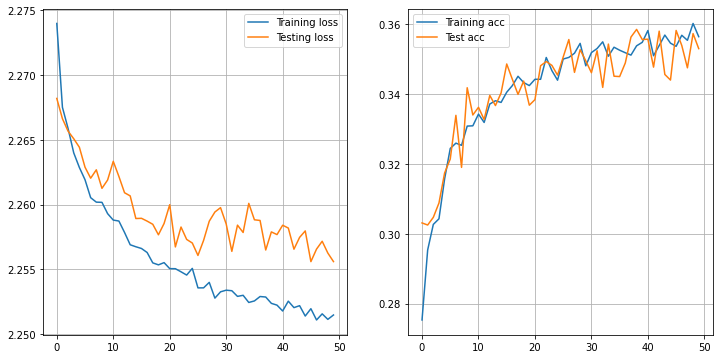

In [16]:
f = plt.figure(figsize=(12,6))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax1.plot(train_losses, label='Training loss')
ax1.plot(val_losses, label='Testing loss')
ax1.legend()
ax1.grid()

ax2.plot(train_accuracies, label='Training acc')
ax2.plot(val_accuracies, label='Test acc')
ax2.legend()
ax2.grid()

In [17]:
confusion_matrix(val_result["predictions"], val_result["targets"])

array([[424,  78, 113,  74,  59,  48,  32,  78,  96,  65],
       [ 43, 313,  33,  35,  13,  25,  33,  32,  61,  80],
       [108,  45, 341, 152, 195, 163, 176, 144,  28,  35],
       [ 28,  65, 100, 272,  94, 221, 128,  75,  50,  57],
       [ 27,  57, 112,  95, 299, 105, 150, 107,  23,  34],
       [ 24,  34,  39,  84,  33, 199,  23,  53,  27,  34],
       [ 20,  58, 106,  83, 136,  80, 320,  46,  17,  26],
       [ 29,  44,  52,  68,  90,  79,  52, 329,  17,  50],
       [237, 126,  78,  60,  55,  55,  45,  60, 577, 163],
       [ 60, 180,  26,  77,  26,  25,  41,  76, 104, 456]])